In [28]:
#loading required libraries
import pandas as pd
import numpy as np

# Visualisations
import matplotlib.pyplot as plt

# Correlation test
from scipy import stats
from scipy.stats import pearsonr

# RMSE
from sklearn.metrics import mean_squared_error,r2_score

# Splitting the data
from sklearn.model_selection import train_test_split

# Linear Regression library
from sklearn.linear_model import LinearRegression

# Statitistical Tests - Z-Test
from statsmodels.stats.weightstats import ztest as ztest

# OLS Regression
import statsmodels.api as sm

# Polynomial regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#Suppressing warnings
import warnings
warnings.filterwarnings("ignore")

In [29]:
MODIS = pd.read_csv(r'D:\Data Science\Nigeria Proj\Intermediate\GEE Data\Nigeria_LGAs_NDVI.csv')
VIIRS = pd.read_csv(r'D:\Data Science\Nigeria Proj\Intermediate\GEE Data\VIIRS_Admin2.csv')

In [30]:
def resampling_monthly(data1:pd.DataFrame)  -> pd.DataFrame:

    data1['date'] = [x.replace('_','-') for x in data1['imageId']]
    data1['date'] = pd.to_datetime(data1['date'])
    data1.set_index('date', inplace=True)
    data1.drop(['system:index','.geo','imageId'], inplace=True, axis=1)
    data1 = data1.resample('M').mean()
    return data1

In [31]:
MODIS_monthly = resampling_monthly(MODIS)
VIIRS_monthly = resampling_monthly(VIIRS)
VIIRS_monthly.head()

,Aba North,Aba South,Abadam,Abaji,Abak,Abakalik,Abeokuta South,AbeokutaNorth,Abi,Aboh-Mba,...,Yorro,Yunusari,Yusufari,Zaki,Zango,ZangonKa,Zaria,Zing,Zurmi,Zuru
date,,,,,,,,,,,,,,,,,,,,,
2012-01-31,0.268050,0.352281,0.203542,0.340406,0.488667,0.408824,0.257684,0.328152,0.437751,0.562139,...,0.308477,0.215817,0.215293,0.224780,0.251446,0.355974,0.260375,0.281968,0.232465,0.261489
2012-02-29,0.238335,0.347813,0.183005,0.343562,0.484379,0.402268,0.307991,0.400243,0.476098,0.548303,...,0.284626,0.202036,0.204313,0.210428,0.233412,0.365204,0.240121,0.254186,0.217644,0.214421
2012-03-31,0.230205,0.324954,0.167582,0.374476,0.468733,0.351400,0.376365,0.494969,0.459950,0.542266,...,0.251443,0.190596,0.190096,0.186877,0.217856,0.366408,0.190373,0.201932,0.203069,0.218718
2012-04-30,0.319688,0.452718,0.171129,0.479652,0.628705,0.515800,0.463213,0.666513,0.587324,0.687049,...,0.335465,0.172199,0.175954,0.198484,0.213826,0.495384,0.254241,0.289355,0.200079,0.252201
2012-05-31,0.379905,0.550024,0.188501,0.634682,0.685151,0.605596,0.462132,0.690816,0.625174,0.691367,...,0.476443,0.191726,0.196864,0.207498,0.202747,0.589854,0.319782,0.455816,0.221730,0.282207


In [32]:
MODIS_2012 =  MODIS_monthly[MODIS_monthly.index >= '2012-01-17'] 

In [33]:
idx = int(input("Enter the number that will represent the region that you want to analyse: "))
print(MODIS_2012.columns[idx])

Aba South


In [34]:
def correlation_VIIRS_MODIS(data1:pd.DataFrame,data2:pd.DataFrame) -> str:
    """
    Here we are going to be carrying out correlation analysis between the different MODIS and VIIRS LGAs
    """
    
    data = pd.concat([data1.iloc[:,idx], data2.iloc[:,idx]], axis=1)

    corrs = data.corr()

    corrs.columns = [f'{data1.columns[idx]}_MODIS',f"{data1.columns[idx]}_VIIRS"]

    return f"The correlation between MODIS and VIIRS for {data1.columns[idx]} is {corrs.iloc[1][0]}"




In [35]:
correlation_VIIRS_MODIS(MODIS_2012,VIIRS_monthly)

'The correlation between MODIS and VIIRS for Aba South is 0.5225694468508021'

In [11]:
def plots(data1:pd.DataFrame, data2:pd.DataFrame):
    data = pd.concat([data1.iloc[:,idx], data2.iloc[:,idx]], axis=1)
    data.columns = [f'{data1.columns[idx]}_MODIS',f"{data1.columns[idx]}_VIIRS"]
    return data.plot(figsize=(20,10), title=f"Temporal Plot between MODIS and VIIRS for {data.columns[0]}")
# Plotting the line plot between two datasets

<Axes: title={'center': 'Temporal Plot between MODIS and VIIRS for Aba South_MODIS'}, xlabel='date'>

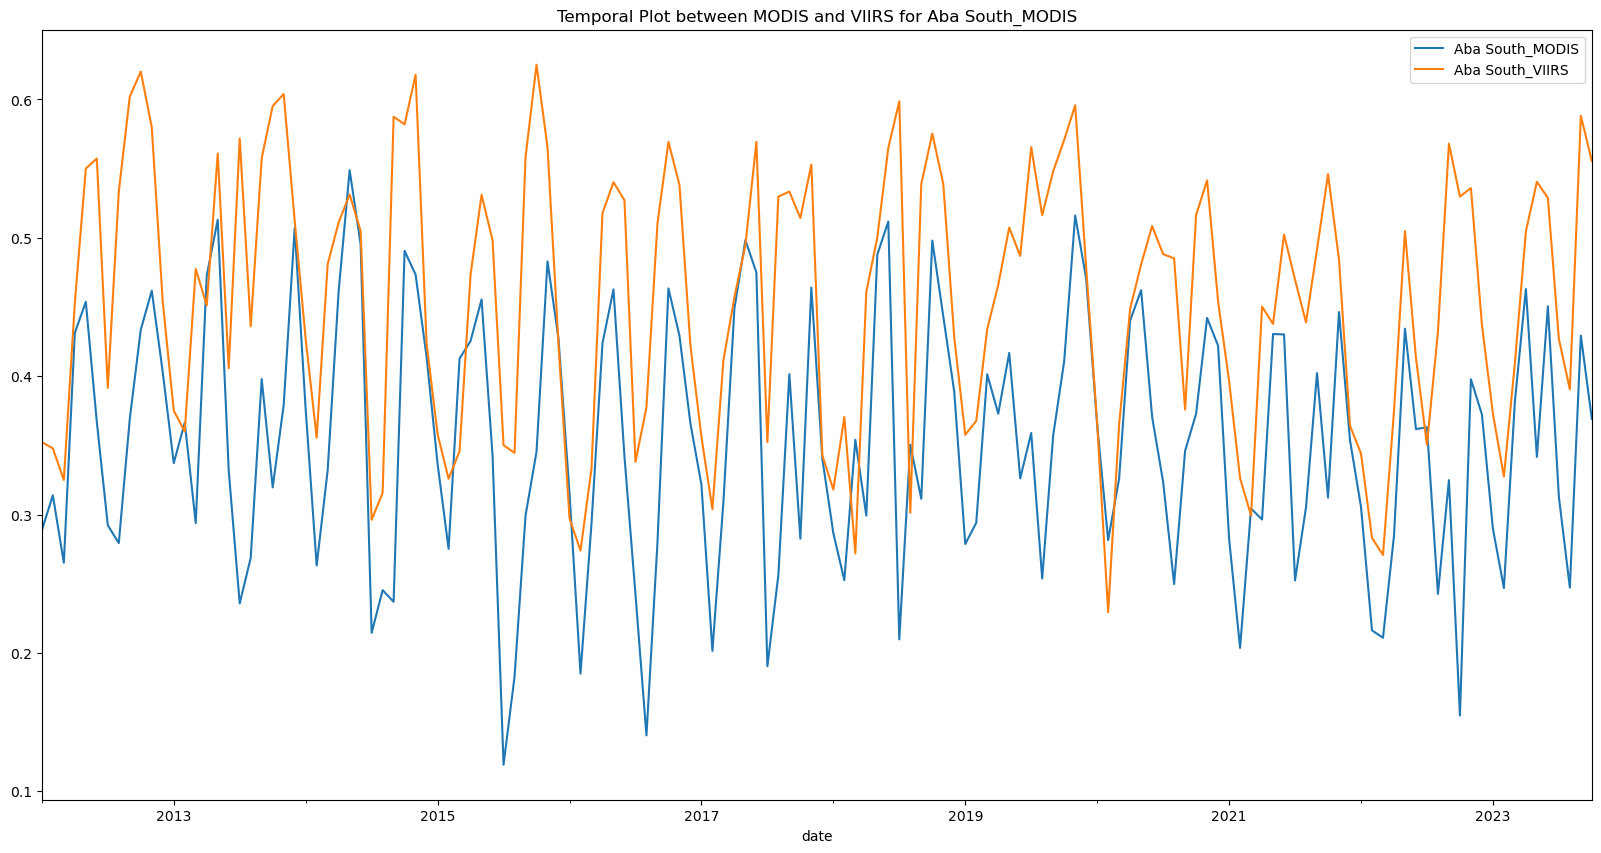

In [36]:
plots(MODIS_2012, VIIRS_monthly)

In [51]:
def regressions(x:pd.DataFrame,y:pd.DataFrame, x_val:pd.DataFrame)->float:
    """
    This function performs a simple linear regression analysis on the MODIS and VIIRS data sets seeing how well the VIIRS data can 
    be used to explain the discontinued MODIS data
    """
    X_train, y_train, X_test, y_test = x.iloc[-int(0.7*x.shape[0]):], y.iloc[-int(0.7*y.shape[0]):],x.iloc[:-int(0.7*x.shape[0])],y.iloc[:-int(0.7*x.shape[0])]
    reg = LinearRegression()
    reg.fit(np.array(X_train.iloc[:,idx]).reshape(-1,1),np.array(y_train.iloc[:,idx]).reshape(-1,1))
    y_pred = reg.predict(np.array(X_test.iloc[:,idx]).reshape(-1,1))

    ### Polynomial Regression
    degree = 4
    polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    polyreg.fit(np.array(X_train.iloc[:,idx]).reshape(-1,1),np.array(y_train.iloc[:,idx]).reshape(-1,1))
    scores = polyreg.score(np.array(X_train.iloc[:,idx]).reshape(-1,1),np.array(y_train.iloc[:,idx]).reshape(-1,1))
    y_val = polyreg.predict(np.array(x_val.iloc[:,idx]).reshape(-1,1))



    print(f"Polynomial regression score is {scores} and {y_val}")
    
    return f"Linear Regression reults are The root mean squared of {X_train.columns[idx]} is {np.sqrt(mean_squared_error(y_pred,y_test.iloc[:,idx]))} and the Adjusted Rsquared is {reg.score(np.array(X_train.iloc[:,idx]).reshape(-1,1), np.array(y_train.iloc[:,idx]).reshape(-1,1))}"
    

In [52]:
regressions(VIIRS_monthly, MODIS_2012, MODIS_2000)

ValueError: Per-column arrays must each be 1-dimensional

In [39]:
MODIS_monthly

,Aba North,Aba South,Abadam,Abaji,Abak,Abakalik,Abeokuta South,AbeokutaNorth,Abi,Aboh-Mba,...,Yorro,Yunusari,Yusufari,Zaki,Zango,ZangonKa,Zaria,Zing,Zurmi,Zuru
date,,,,,,,,,,,,,,,,,,,,,
2000-02-29,0.218837,0.296871,0.154790,0.303720,0.430323,0.312508,0.202479,0.260201,0.418745,0.444228,...,0.247548,0.179650,0.177738,0.188413,0.181807,0.291688,0.201132,0.223852,0.181411,0.229032
2000-03-31,0.230819,0.318873,0.163574,0.334961,0.377311,0.311978,0.286406,0.370955,0.357157,0.425214,...,0.249616,0.182903,0.178278,0.187801,0.180132,0.328095,0.201298,0.221400,0.180378,0.218941
2000-04-30,0.310644,0.468328,0.158243,0.444912,0.530936,0.404365,0.449107,0.557888,0.514744,0.516078,...,0.301739,0.180571,0.176689,0.184249,0.177352,0.416495,0.227224,0.270098,0.186199,0.257124
2000-05-31,0.345238,0.467134,0.163408,0.556997,0.558513,0.466480,0.532497,0.635457,0.524762,0.646033,...,0.430889,0.183127,0.184539,0.193129,0.179270,0.524065,0.285629,0.399729,0.198312,0.273974
2000-06-30,0.270304,0.395392,0.180106,0.679238,0.432766,0.395312,0.498769,0.628626,0.376667,0.532114,...,0.535178,0.189181,0.200049,0.201521,0.195953,0.632955,0.411466,0.498256,0.282531,0.374247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,0.293504,0.450416,0.281540,0.490186,0.601326,0.497874,0.353547,0.590982,0.628965,0.646442,...,0.536448,0.261749,0.223584,0.303041,0.328893,0.578644,0.343229,0.478238,0.362245,0.347424
2023-07-31,0.183352,0.312797,0.261378,0.521830,0.301071,0.321447,0.191659,0.413818,0.310703,0.371669,...,0.551169,0.295262,0.274186,0.422653,0.461907,0.476453,0.452149,0.552266,0.471028,0.372649
2023-08-31,0.179213,0.247147,0.355092,0.565701,0.419287,0.411735,0.254832,0.413215,0.362126,0.384368,...,0.564202,0.379908,0.354262,0.470123,0.498227,0.656066,0.548759,0.543536,0.596746,0.541728


In [41]:
MODIS_2000 = MODIS_monthly[MODIS_monthly.index<='2012']